# NMA Robolympics: Controlling robots using reinforcement learning

**By Neuromatch Academy**

__Content creators:__ Roman Vaxenburg, Diptodip Deb, Srinivas Turaga, Mobin Nesari

__Production editors:__ Spiros Chavlis

---
# Objectives
# Objective

This notebook provides a comprehensive example of modern reinforcement learning infrastructure, training workflows, and performance analysis using state-of-the-art algorithms. We will use the [Gymnasium](https://gymnasium.farama.org/) MuJoCo locomotion environment and [Stable Baselines 3](https://stable-baselines3.readthedocs.io/) reinforcement learning agents to learn policies for the challenging 2D `Hopper-v5` robot locomotion task.

We will demonstrate how to set up and analyze the environment, train multiple RL algorithms (A2C, DDPG, PPO, SAC, TD3), and visualize both learning curves and agent performance through video recordings. This example provides a solid foundation for understanding different RL paradigms - from on-policy methods like PPO to off-policy algorithms like SAC and TD3. The notebook includes a random agent baseline to clearly illustrate the learning progress and effectiveness of each algorithm.

Even though this example focuses on the Hopper locomotion task, you can easily extend it to more complex environments such as `Ant-v5`, `Humanoid-v5`, or `Walker2d-v5` by simply changing the environment name. We encourage you to explore the [Gymnasium MuJoCo environments](https://gymnasium.farama.org/environments/mujoco/) documentation to understand the observation and action spaces of different robots.

We would also suggest exploring the [Stable Baselines 3 documentation](https://stable-baselines3.readthedocs.io/) for advanced hyperparameter tuning and the [PyTorch](https://pytorch.org/) ecosystem for custom network architectures.

For a comprehensive introduction to Reinforcement Learning theory and practice, we recommend checking out the [Spinning Up in Deep RL](https://spinningup.openai.com/) course by OpenAI and the classic [Sutton & Barto textbook](http://incompleteideas.net/book/the-book.html).

# Colab limits

Please note that due to the Colab usage limits on the one hand, and the compute requirements of the project on the other hand, most likely you won't be able to leverage Colab's GPU for a sufficient amount of time. Instead, we suggest working in CPU-only mode (it shouldn't slow you down very much, typical RL workloads are CPU-bound anyway). Make sure you're not using GPU by doing Runtime -> Change runtime type -> Hardware accelerator -> None.
**bold text**

# Setup

In [ ]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
!pip install gymnasium[mujoco] --quiet
!pip install stable-baselines3[extra] --quiet
!pip install torch torchvision torchaudio --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet==1.5.27 --quiet
!apt-get install -y xvfb python-opengl ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Setup virtual display
# @markdown In this cell, we will setup a virtual display to capture image and videos
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
# @title Imports
# @markdown Imports required libraries and modules
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import torch
import imageio
from IPython.display import Video, display
import warnings
from IPython.display import HTML
import base64
warnings.filterwarnings('ignore')

In [ ]:
# @title Training parameters
# @markdown `TOTAL_TIMESTEPS` has been set to 10000, feel free to change it
TOTAL_TIMESTEPS = 10000
LOG_DIR = "./logs/"
VIDEO_DIR = "./videos/"

In [ ]:

# @title Create directories
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Record and display videos utilities
# @markdown Using these two functions to record and display video inline
def record_video(model, env_name, video_filename, num_episodes=1):
    """Record video of trained model playing the environment"""

    # Create environment for recording
    env = gym.make(env_name, render_mode='rgb_array')

    frames = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0

        while not (done or truncated):
            # Render frame
            frame = env.render()
            frames.append(frame)

            # Get action from model
            action, _ = model.predict(obs, deterministic=True)

            # Take step in environment
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward

        print(f"Episode {episode + 1} reward: {episode_reward:.2f}")

    env.close()

    # Save video
    imageio.mimsave(video_filename, frames, fps=30)
    print(f"Video saved as {video_filename}")

    return episode_reward

def display_video_html(video_path, title="Video"):
    """Display video using HTML5 video player"""
    video = open(video_path, 'rb').read()
    video_encoded = base64.b64encode(video).decode('ascii')
    video_tag = f'''
    <h3>{title}</h3>
    <video width="600" height="400" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''
    return HTML(video_tag)

In [ ]:
# @title Callback logging
# @markdown Callback for logging training progress
class TrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        if len(self.locals.get('infos', [])) > 0:
            for info in self.locals['infos']:
                if 'episode' in info:
                    self.rewards.append(info['episode']['r'])
                    self.episode_lengths.append(info['episode']['l'])
        return True

# 🦗 Hopper-v5 Environment

## Overview

The Hopper-v5 is a 2D one-legged robot locomotion task from the [MuJoCo](https://mujoco.org/) physics simulator, available through [Gymnasium](https://gymnasium.farama.org/environments/mujoco/hopper/). The agent must learn to control a monopedal robot to hop forward as fast as possible while maintaining balance and avoiding falls.
---bold text


## Environment Specifications

__Action Space__
- **Type**: `Box(3,)` - Continuous action space
- **Range**: `[-1, 1]` for each action dimension
- **Description**: 3-dimensional continuous control vector representing torques applied to joints
  - `action[0]`: Torque applied to the hip joint (thigh-leg connection)
  - `action[1]`: Torque applied to the knee joint (leg-foot connection)  
  - `action[2]`: Torque applied to the ankle joint (foot-ground interaction)

__Observation Space__
- **Type**: `Box(11,)` - 11-dimensional continuous observation vector
- **Components**:
  - `obs[0]`: z-coordinate of the torso (height)
  - `obs[1]`: angle of the torso (pitch)
  - `obs[2]`: angle of the thigh joint
  - `obs[3]`: angle of the leg joint
  - `obs[4]`: angle of the foot joint
  - `obs[5]`: velocity of the z-coordinate of the torso
  - `obs[6]`: angular velocity of the torso
  - `obs[7]`: angular velocity of the thigh joint
  - `obs[8]`: angular velocity of the leg joint
  - `obs[9]`: angular velocity of the foot joint
  - `obs[10]`: x-coordinate of the torso (horizontal position)

In [ ]:
env_name = "Hopper-v5"
env = gym.make(env_name)

print(f"Environment: {env_name}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Action space shape: {env.action_space.shape}")
print(f"Action space bounds: [{env.action_space.low}, {env.action_space.high}]")

Environment: Hopper-v5
Observation space: Box(-inf, inf, (11,), float64)
Action space: Box(-1.0, 1.0, (3,), float32)
Action space shape: (3,)
Action space bounds: [[-1. -1. -1.], [1. 1. 1.]]


### Reward Function
The reward function encourages forward locomotion while penalizing control effort:

```
reward = reward_forward + reward_control + reward_survive
```

- **Forward Reward**: `reward_forward = (x_after - x_before) / dt`
  - Encourages forward movement by rewarding positive x-axis velocity
  - Typical range: 0.5 to 3.0 for successful hopping
  
- **Control Penalty**: `reward_control = -0.001 * sum(action²)`
  - Penalizes large control inputs to encourage energy efficiency
  - Typical range: -0.003 to 0.0
  
- **Survival Reward**: `reward_survive = 1.0`
  - Constant reward for staying alive (not terminating)
  - Encourages the agent to maintain balance

### Termination Conditions
The episode terminates when any of the following conditions are met:

1. **Height Constraint**: `z_torso < 0.7`
   - The robot falls below a minimum height threshold
   - Indicates the robot has fallen or collapsed

2. **Angle Constraint**: `|torso_angle| > 0.2`
   - The torso angle exceeds ±0.2 radians (~±11.5 degrees)
   - Prevents the robot from falling over backward or forward

3. **Maximum Episode Length**: 1000 timesteps
   - Episodes are truncated after 1000 steps to prevent infinite episodes
   - Corresponds to 1000 * 0.008 = 8 seconds of simulation time

### Episode Information
- **Physics Timestep**: 0.008 seconds per step
- **Max Episode Steps**: 1000
- **Max Episode Duration**: ~8 seconds
- **Typical Episode Reward**:
  - Random agent: -200 to 200
  - Well-trained agent: 1000 to 4000+



## Environment Preview


🎮 Environment Preview:


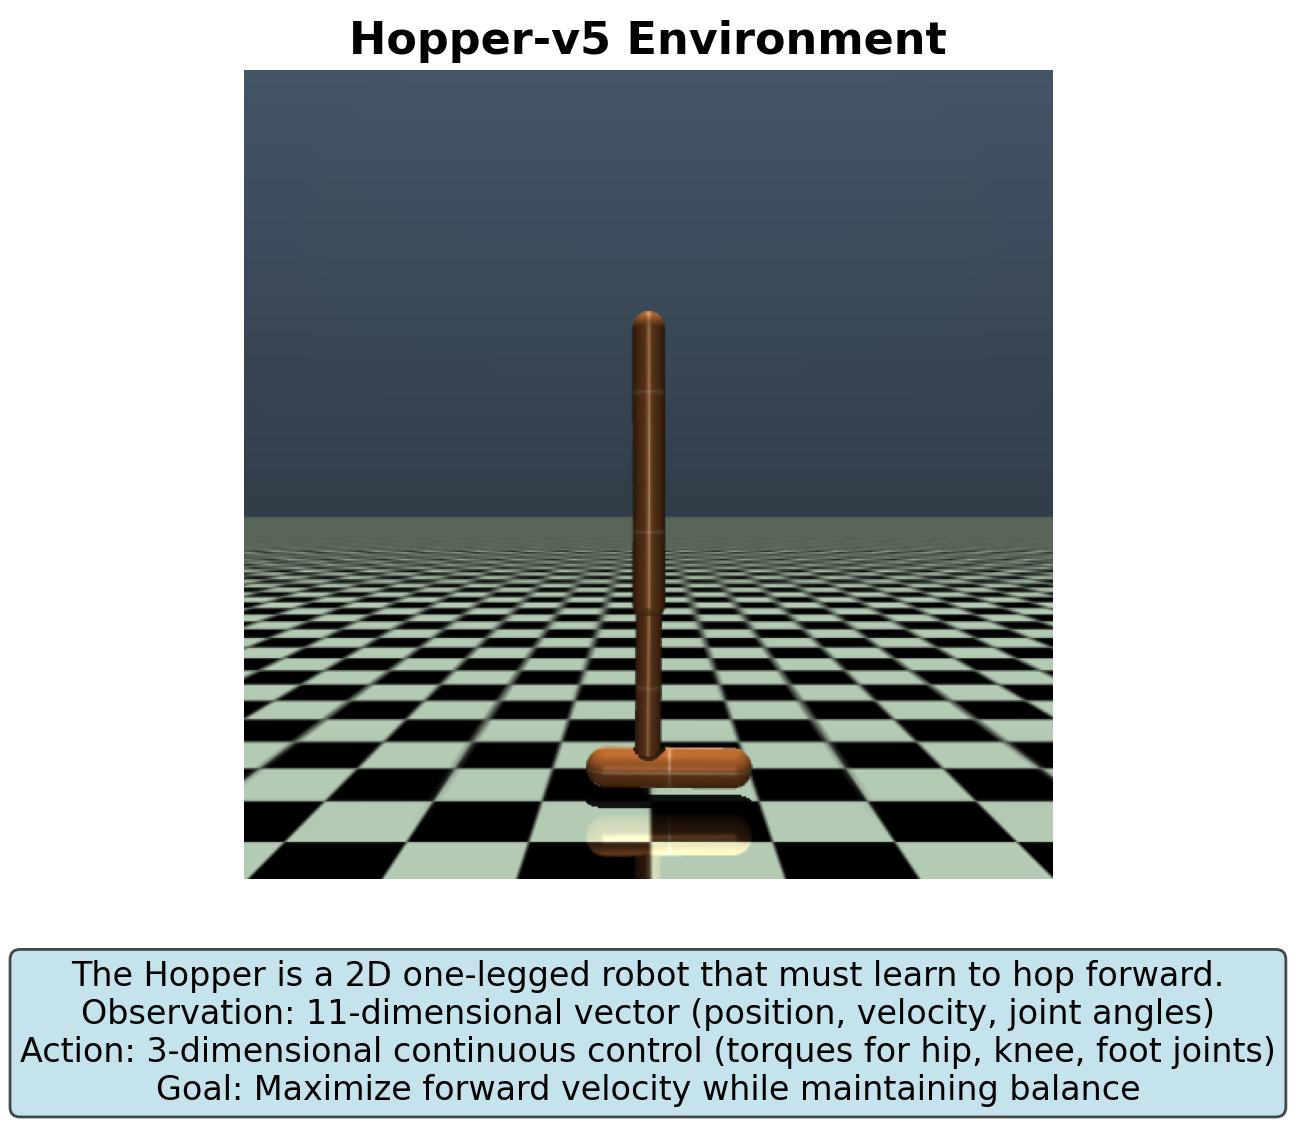

In [ ]:
# Display environment image
print("\n🎮 Environment Preview:")
print("=" * 30)

# Capture and display a sample frame from the environment
env_preview = gym.make(env_name, render_mode='rgb_array')
obs, info = env_preview.reset()
frame = env_preview.render()

plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.title("Hopper-v5 Environment", fontsize=16, fontweight='bold')
plt.text(0.5, -0.1, "The Hopper is a 2D one-legged robot that must learn to hop forward.\n"
                    "Observation: 11-dimensional vector (position, velocity, joint angles)\n"
                    "Action: 3-dimensional continuous control (torques for hip, knee, foot joints)\n"
                    "Goal: Maximize forward velocity while maintaining balance",
         transform=plt.gca().transAxes, ha='center', va='top', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
plt.axis('off')
plt.tight_layout()
plt.show()

---
# Agents

## 🎲 Random Agent

In [ ]:
# Create random agent for comparison
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def predict(self, obs, deterministic=True):
        return self.action_space.sample(), None

print("Generating random agent video for comparison...")

# Create random agent
random_agent = RandomAgent(env.action_space)

# Generate random agent video
video_path_random = os.path.join(VIDEO_DIR, "random_hopper.mp4")
reward_random = record_video(random_agent, env_name, video_path_random)

print("Random agent video generated successfully ✅")
print("\n🎲 Random Agent (Baseline):")
display(display_video_html(video_path_random, "Random Agent Playing Hopper-v5"))
print(f"Episode reward: {reward_random:.2f}")
print("📝 Note: Random agent takes completely random actions - this shows untrained performance")

Generating random agent video for comparison...
Episode 1 reward: 13.62
Video saved as ./videos/random_hopper.mp4
Random agent video generated successfully ✅

🎲 Random Agent (Baseline):


Episode reward: 13.62
📝 Note: Random agent takes completely random actions - this shows untrained performance


## 1️⃣ A2C (Advantage Actor-Critic)

**A2C** is a synchronous, on-policy reinforcement learning algorithm that combines the benefits of both value-based and policy-based methods. It uses an actor-critic architecture where the **actor** learns a policy π(a|s) to select actions, while the **critic** learns a value function V(s) to estimate state values.

### Key Features:
- **Advantage Function**: Uses the advantage A(s,a) = Q(s,a) - V(s) to reduce variance in policy gradient updates
- **On-Policy**: Learns from actions taken by the current policy, ensuring stable learning
- **Synchronous Updates**: All parallel environments step simultaneously before updating the model
- **Shared Networks**: Actor and critic often share lower-level representations for efficiency

### Algorithm Components:
- **Actor Network**: Outputs action probabilities for continuous control (via mean and std)
- **Critic Network**: Estimates state values V(s) for advantage calculation
- **Advantage Estimation**: A(s,a) = r + γV(s') - V(s), where γ is the discount factor

### Hyperparameters:
- **Learning Rate**: 0.0007 (balanced for stable convergence)
- **n_steps**: 5 (number of steps before each update)
- **Gamma**: 0.99 (discount factor for future rewards)
- **GAE Lambda**: 1.0 (Generalized Advantage Estimation parameter)

A2C is particularly effective for continuous control tasks like Hopper due to its stable policy updates and efficient use of experience. It's simpler than PPO but often achieves competitive performance with proper tuning.

In [ ]:
print("Training A2C...")

# Create monitored environment
env_a2c = Monitor(gym.make(env_name), LOG_DIR + "a2c/")
env_a2c = DummyVecEnv([lambda: env_a2c])

# Initialize A2C model
model_a2c = A2C(
    "MlpPolicy",
    env_a2c,
    verbose=1,
    tensorboard_log=LOG_DIR + "a2c_tensorboard/",
    learning_rate=0.0007,
    n_steps=5,
    gamma=0.99,
    gae_lambda=1.0,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_rms_prop=True,
    rms_prop_eps=1e-05,
    use_sde=False,
    sde_sample_freq=-1,
    normalize_advantage=False,
    device="auto"
)

# Train A2C
callback_a2c = TrainingCallback()
model_a2c.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback_a2c)
model_a2c.save("a2c_hopper")
video_path_a2c = os.path.join(VIDEO_DIR, "a2c_hopper.mp4")
reward_a2c = record_video(model_a2c, env_name, video_path_a2c)

print("A2C training completed! ✅")


Training A2C...
Using cpu device
Logging to ./logs/a2c_tensorboard/A2C_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 27.4     |
|    ep_rew_mean        | 24.5     |
| time/                 |          |
|    fps                | 301      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.19    |
|    explained_variance | 0.214    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -8.99    |
|    std                | 0.978    |
|    value_loss         | 24       |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 33       |
|    ep_rew_mean        | 33.5     |
| time/                 |          |
|    fps                | 302      |
|    iterations         | 200      |
| 

In [ ]:
print("\n🤖 A2C Performance:")
display(display_video_html(video_path_a2c, "A2C Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_a2c:.2f}")


🤖 A2C Performance:


Final episode reward: 75.55


## 2️⃣ DDPG (Deep Deterministic Policy Gradient)

**DDPG** is an off-policy reinforcement learning algorithm designed for continuous action spaces. It combines the actor-critic architecture with deep neural networks and borrows ideas from Deep Q-Networks (DQN) to create a deterministic policy gradient method that can handle high-dimensional, continuous control tasks.

### Key Features:
* **Deterministic Policy**: Learns a deterministic policy μ(s) that directly outputs actions rather than action probabilities
* **Off-Policy Learning**: Uses experience replay to learn from past experiences, improving sample efficiency
* **Target Networks**: Employs slowly-updating target networks for both actor and critic to stabilize training
* **Exploration Strategy**: Uses noise injection (typically Ornstein-Uhlenbeck) during training for exploration

### Algorithm Components:
* **Actor Network**: Outputs deterministic actions μ(s|θ^μ) for continuous control
* **Critic Network**: Estimates action-value function Q(s,a|θ^Q) for given state-action pairs
* **Target Networks**: Soft-updated copies of actor (μ') and critic (Q') networks for stable learning
* **Experience Replay Buffer**: Stores transitions (s,a,r,s') for off-policy learning

## Learning Process:
* **Critic Update**: Minimize TD error using target Q-values: L = E[(Q(s,a) - y)²] where y = r + γQ'(s',μ'(s'))
* **Actor Update**: Maximize expected Q-value: ∇θ^μ J ≈ E[∇aQ(s,a)|s,a=μ(s) ∇θ^μ μ(s)]
* **Target Update**: Soft update both target networks: θ' ← τθ + (1-τ)θ'

### Hyperparameters:
* **Learning Rate**: 0.001 (actor), 0.002 (critic) - typically different rates for actor and critic
* **Batch Size**: 64-256 (size of minibatch sampled from replay buffer)
* **Replay Buffer Size**: 1e6 (maximum number of transitions stored)
* **Tau**: 0.005 (soft update parameter for target networks)
* **Gamma**: 0.99 (discount factor for future rewards)
* **Noise**: Ornstein-Uhlenbeck or Gaussian noise for exploration

DDPG is particularly effective for continuous control tasks like robotic manipulation and locomotion due to its ability to learn deterministic policies in high-dimensional action spaces. While it can be sensitive to hyperparameters and may suffer from overestimation bias, it remains a foundational algorithm for continuous control.

In [ ]:
print("Training DDPG...")

# Create monitored environment
env_ddpg = Monitor(gym.make(env_name), LOG_DIR + "ddpg/")

# Action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize DDPG model
model_ddpg = DDPG(
    "MlpPolicy",
    env_ddpg,
    action_noise=action_noise,
    verbose=1,
    tensorboard_log=LOG_DIR + "ddpg_tensorboard/",
    learning_rate=0.001,
    buffer_size=2000,
    learning_starts=100,
    batch_size=100,
    tau=0.005,
    gamma=0.98,
    train_freq=1,
    gradient_steps=1,
    device="auto"
)

# Train DDPG
callback_ddpg = TrainingCallback()
model_ddpg.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback_ddpg)
model_ddpg.save("ddpg_hopper")

Training DDPG...
Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ddpg_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 481      |
|    time_elapsed    | 0        |
|    total_timesteps | 105      |
| train/             |          |
|    actor_loss      | -1.09    |
|    critic_loss     | 0.248    |
|    learning_rate   | 0.001    |
|    n_updates       | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | 11.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 183      |
|    time_elapsed    | 0        |
|    total_timesteps | 130      |
| train/             |          |
|    actor_loss      | -0.757   |
|    

In [ ]:
print("\n🤖 DDPG Performance:")
video_path_ddpg = os.path.join(VIDEO_DIR, "ddpg_hopper.mp4")
reward_ddpg = record_video(model_ddpg, env_name, video_path_ddpg)
display(display_video_html(video_path_ddpg, "DDPG Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_ddpg:.2f}")


🤖 DDPG Performance:
Episode 1 reward: 185.40
Video saved as ./videos/ddpg_hopper.mp4


Final episode reward: 185.40


## 3️⃣ PPO (Proximal Policy Optimization)

**PPO** is an on-policy reinforcement learning algorithm that strikes a balance between sample efficiency and ease of implementation. It's designed to address the instability issues of policy gradient methods by constraining policy updates to prevent destructively large changes while maintaining good performance across a wide range of tasks.

### Key Features:
* **Clipped Surrogate Objective**: Prevents policy updates from being too large by clipping the probability ratio
* **On-Policy with Multiple Epochs**: Reuses collected data for multiple gradient steps while staying approximately on-policy
* **Adaptive KL Penalty**: Optional mechanism to adaptively control the magnitude of policy updates
* **Robust Performance**: Reliable across diverse environments with minimal hyperparameter tuning

### Algorithm Components:
* **Actor Network**: Outputs action probabilities π(a|s) for stochastic policy
* **Critic Network**: Estimates state values V(s) for advantage calculation
* **Clipped Objective**: L^CLIP(θ) = E[min(r_t(θ)A_t, clip(r_t(θ), 1-ε, 1+ε)A_t)]
* **Probability Ratio**: r_t(θ) = π_θ(a_t|s_t) / π_θ_old(a_t|s_t)

### Learning Process:
* **Data Collection**: Collect trajectories using current policy for n_steps
* **Advantage Estimation**: Compute advantages using GAE: A_t = Σ(γλ)^l δ_{t+l}
* **Policy Update**: Optimize clipped objective for multiple epochs on collected data
* **Value Function Update**: Minimize squared error between V(s) and returns

### Hyperparameters:
* **Learning Rate**: 0.0003 (often uses learning rate scheduling)
* **n_steps**: 2048 (number of steps collected before each update)
* **Batch Size**: 64 (minibatch size for SGD updates)
* **n_epochs**: 10 (number of optimization epochs per data collection)
* **Clip Range**: 0.2 (ε parameter for clipping the probability ratio)
* **Gamma**: 0.99 (discount factor for future rewards)
* **GAE Lambda**: 0.95 (parameter for Generalized Advantage Estimation)

PPO is considered the gold standard for many reinforcement learning applications due to its reliability and consistent performance. It's particularly effective for both discrete and continuous control tasks, making it a popular choice for robotics, game playing, and other complex decision-making problems.

In [ ]:
print("Training PPO...")

# Create monitored environment
env_ppo = Monitor(gym.make(env_name), LOG_DIR + "ppo/")
env_ppo = DummyVecEnv([lambda: env_ppo])

# Initialize PPO model
model_ppo = PPO(
    "MlpPolicy",
    env_ppo,
    verbose=1,
    tensorboard_log=LOG_DIR + "ppo_tensorboard/",
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_sde=False,
    sde_sample_freq=-1,
    device="auto"
)

# Train PPO
callback_ppo = TrainingCallback()
model_ppo.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback_ppo)
model_ppo.save("ppo_hopper")

print("PPO training completed! ✅")

Training PPO...
Using cpu device
Logging to ./logs/ppo_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.5     |
| time/              |          |
|    fps             | 815      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 25.8       |
|    ep_rew_mean          | 23.4       |
| time/                   |            |
|    fps                  | 556        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02066369 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.22      |
|    explaine

In [ ]:
print("\n🤖 PPO Performance:")
video_path_ppo = os.path.join(VIDEO_DIR, "ppo_hopper.mp4")
reward_ppo = record_video(model_ppo, env_name, video_path_ppo)
display(display_video_html(video_path_ppo, "PPO Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_ppo:.2f}")

## 4️⃣ SAC (Soft Actor-Critic)

**SAC** is an off-policy reinforcement learning algorithm that maximizes both expected return and entropy of the policy. It combines the sample efficiency of off-policy methods with the stability of entropy regularization, making it particularly effective for continuous control tasks where exploration is crucial.

### Key Features:
* **Maximum Entropy Framework**: Optimizes a trade-off between reward maximization and policy entropy
* **Off-Policy Learning**: Uses experience replay for sample-efficient learning from past experiences
* **Stochastic Policy**: Learns a stochastic policy that naturally handles exploration
* **Automatic Temperature Tuning**: Adaptively adjusts the entropy regularization coefficient

### Algorithm Components:
* **Actor Network**: Outputs mean and log-std for a stochastic policy π(a|s)
* **Twin Critic Networks**: Two Q-networks (Q₁, Q₂) to mitigate overestimation bias
* **Target Critics**: Soft-updated target networks for stable learning
* **Temperature Parameter**: α controls the entropy-reward trade-off in the objective

### Learning Process:
* **Entropy-Regularized Objective**: J(π) = E[Σ(r_t + α log π(a_t|s_t))]
* **Critic Update**: Minimize TD error using minimum of twin Q-values for target
* **Actor Update**: Maximize entropy-regularized Q-value: E[Q(s,a) - α log π(a|s)]
* **Temperature Update**: Adjust α to maintain target entropy automatically

### Hyperparameters:
* **Learning Rate**: 0.0003 (typically same for actor, critics, and temperature)
* **Batch Size**: 256 (larger batches often beneficial for stability)
* **Replay Buffer Size**: 1e6 (large buffer for diverse experience)
* **Tau**: 0.005 (soft update coefficient for target networks)
* **Gamma**: 0.99 (discount factor for future rewards)
* **Target Entropy**: -dim(action_space) (automatic temperature tuning target)
* **Update Frequency**: 1 (gradient steps per environment step)

SAC is particularly effective for continuous control tasks requiring exploration, such as robotic manipulation and locomotion. Its entropy regularization encourages exploration while the off-policy nature provides sample efficiency. The algorithm is robust to hyperparameters and often achieves state-of-the-art performance on continuous control benchmarks.

In [ ]:
print("Training SAC...")

# Create monitored environment
env_sac = Monitor(gym.make(env_name), LOG_DIR + "sac/")

# Initialize SAC model
model_sac = SAC(
    "MlpPolicy",
    env_sac,
    verbose=1,
    tensorboard_log=LOG_DIR + "sac_tensorboard/",
    learning_rate=0.0003,
    buffer_size=300000,
    learning_starts=100,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
    target_update_interval=1,
    target_entropy="auto",
    use_sde=False,
    sde_sample_freq=-1,
    use_sde_at_warmup=False,
    device="auto"
)

# Train SAC
callback_sac = TrainingCallback()
model_sac.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback_sac)
model_sac.save("sac_hopper")

print("SAC training completed! ✅")

Training SAC...
Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/sac_tensorboard/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | 16.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 589      |
|    time_elapsed    | 0        |
|    total_timesteps | 104      |
| train/             |          |
|    actor_loss      | -2.23    |
|    critic_loss     | 6.01     |
|    ent_coef        | 0.999    |
|    ent_coef_loss   | -0.00299 |
|    learning_rate   | 0.0003   |
|    n_updates       | 3        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 14.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 2        |
|    total_timesteps | 169      |
| train/

In [ ]:
print("\n🤖 SAC Performance:")
video_path_sac = os.path.join(VIDEO_DIR, "sac_hopper.mp4")
reward_sac = record_video(model_sac, env_name, video_path_sac)
display(display_video_html(video_path_sac, "SAC Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_sac:.2f}")


🤖 SAC Performance:
Episode 1 reward: 221.52
Video saved as ./videos/sac_hopper.mp4


Final episode reward: 221.52


## 5️⃣ TD3 (Twin Delayed Deep Deterministic Policy Gradient)

**TD3** is an off-policy reinforcement learning algorithm that addresses the overestimation bias and instability issues of DDPG. It introduces three key improvements: twin critic networks, delayed policy updates, and target policy smoothing to achieve more stable and reliable learning in continuous control tasks.

### Key Features:
* **Twin Critic Networks**: Uses two Q-networks and takes the minimum to reduce overestimation bias
* **Delayed Policy Updates**: Updates the actor less frequently than critics to reduce error accumulation
* **Target Policy Smoothing**: Adds noise to target actions to prevent overfitting to narrow peaks
* **Deterministic Policy**: Learns a deterministic policy with explicit exploration noise during training

### Algorithm Components:
* **Actor Network**: Outputs deterministic actions μ(s|θ^μ) for continuous control
* **Twin Critic Networks**: Two Q-networks (Q₁, Q₂) that estimate action-value functions
* **Target Networks**: Soft-updated copies of actor (μ') and both critics (Q₁', Q₂')
* **Experience Replay Buffer**: Stores transitions for off-policy learning

### Learning Process:
* **Critic Update**: Minimize TD error using minimum of twin target Q-values: y = r + γ min(Q₁'(s',ã), Q₂'(s',ã))
* **Target Action**: ã = μ'(s') + clip(ε, -c, c) where ε ~ N(0,σ) for smoothing
* **Actor Update**: Maximize Q₁(s,μ(s)) every d steps (delayed updates)
* **Target Update**: Soft update all target networks: θ' ← τθ + (1-τ)θ'

### Three Key Innovations:
* **Clipped Double Q-Learning**: Use min(Q₁'(s',ã), Q₂'(s',ã)) for target computation
* **Delayed Policy Updates**: Update actor every d=2 steps while updating critics every step
* **Target Policy Smoothing**: Add clipped noise to target actions to regularize learning

### Hyperparameters:
* **Learning Rate**: 0.001 (actor), 0.001 (critics) - often same for both
* **Batch Size**: 256 (larger batches typically beneficial)
* **Replay Buffer Size**: 1e6 (large buffer for diverse experience)
* **Tau**: 0.005 (soft update coefficient for target networks)
* **Gamma**: 0.99 (discount factor for future rewards)
* **Policy Delay**: 2 (update actor every 2 critic updates)
* **Target Noise**: 0.2 (standard deviation of target policy smoothing noise)
* **Noise Clip**: 0.5 (clipping range for target policy smoothing)

TD3 is particularly effective for continuous control tasks where DDPG struggles with instability. It's simpler than SAC but often achieves competitive performance with better sample efficiency than vanilla DDPG. The algorithm is robust and reliable, making it a popular choice for robotics and control applications.

In [ ]:
print("Training TD3...")

# Create monitored environment
env_td3 = Monitor(gym.make(env_name), LOG_DIR + "td3/")

# Action noise for exploration
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize TD3 model
model_td3 = TD3(
    "MlpPolicy",
    env_td3,
    action_noise=action_noise,
    verbose=1,
    tensorboard_log=LOG_DIR + "td3_tensorboard/",
    learning_rate=0.001,
    buffer_size=200000,
    learning_starts=100,
    batch_size=100,
    tau=0.005,
    gamma=0.98,
    train_freq=1,
    gradient_steps=1,
    policy_delay=2,
    target_policy_noise=0.2,
    target_noise_clip=0.5,
    device="auto"
)

# Train TD3
callback_td3 = TrainingCallback()
model_td3.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback_td3)
model_td3.save("td3_hopper")

print("TD3 training completed! ✅")

In [21]:
print("\n🤖 TD3 Performance:")
video_path_td3 = os.path.join(VIDEO_DIR, "td3_hopper.mp4")
reward_td3 = record_video(model_td3, env_name, video_path_td3)
display(display_video_html(video_path_td3, "TD3 Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_td3:.2f}")


🤖 TD3 Performance:
Episode 1 reward: 163.29
Video saved as ./videos/td3_hopper.mp4


Final episode reward: 163.29


## 📊 Learning Curves

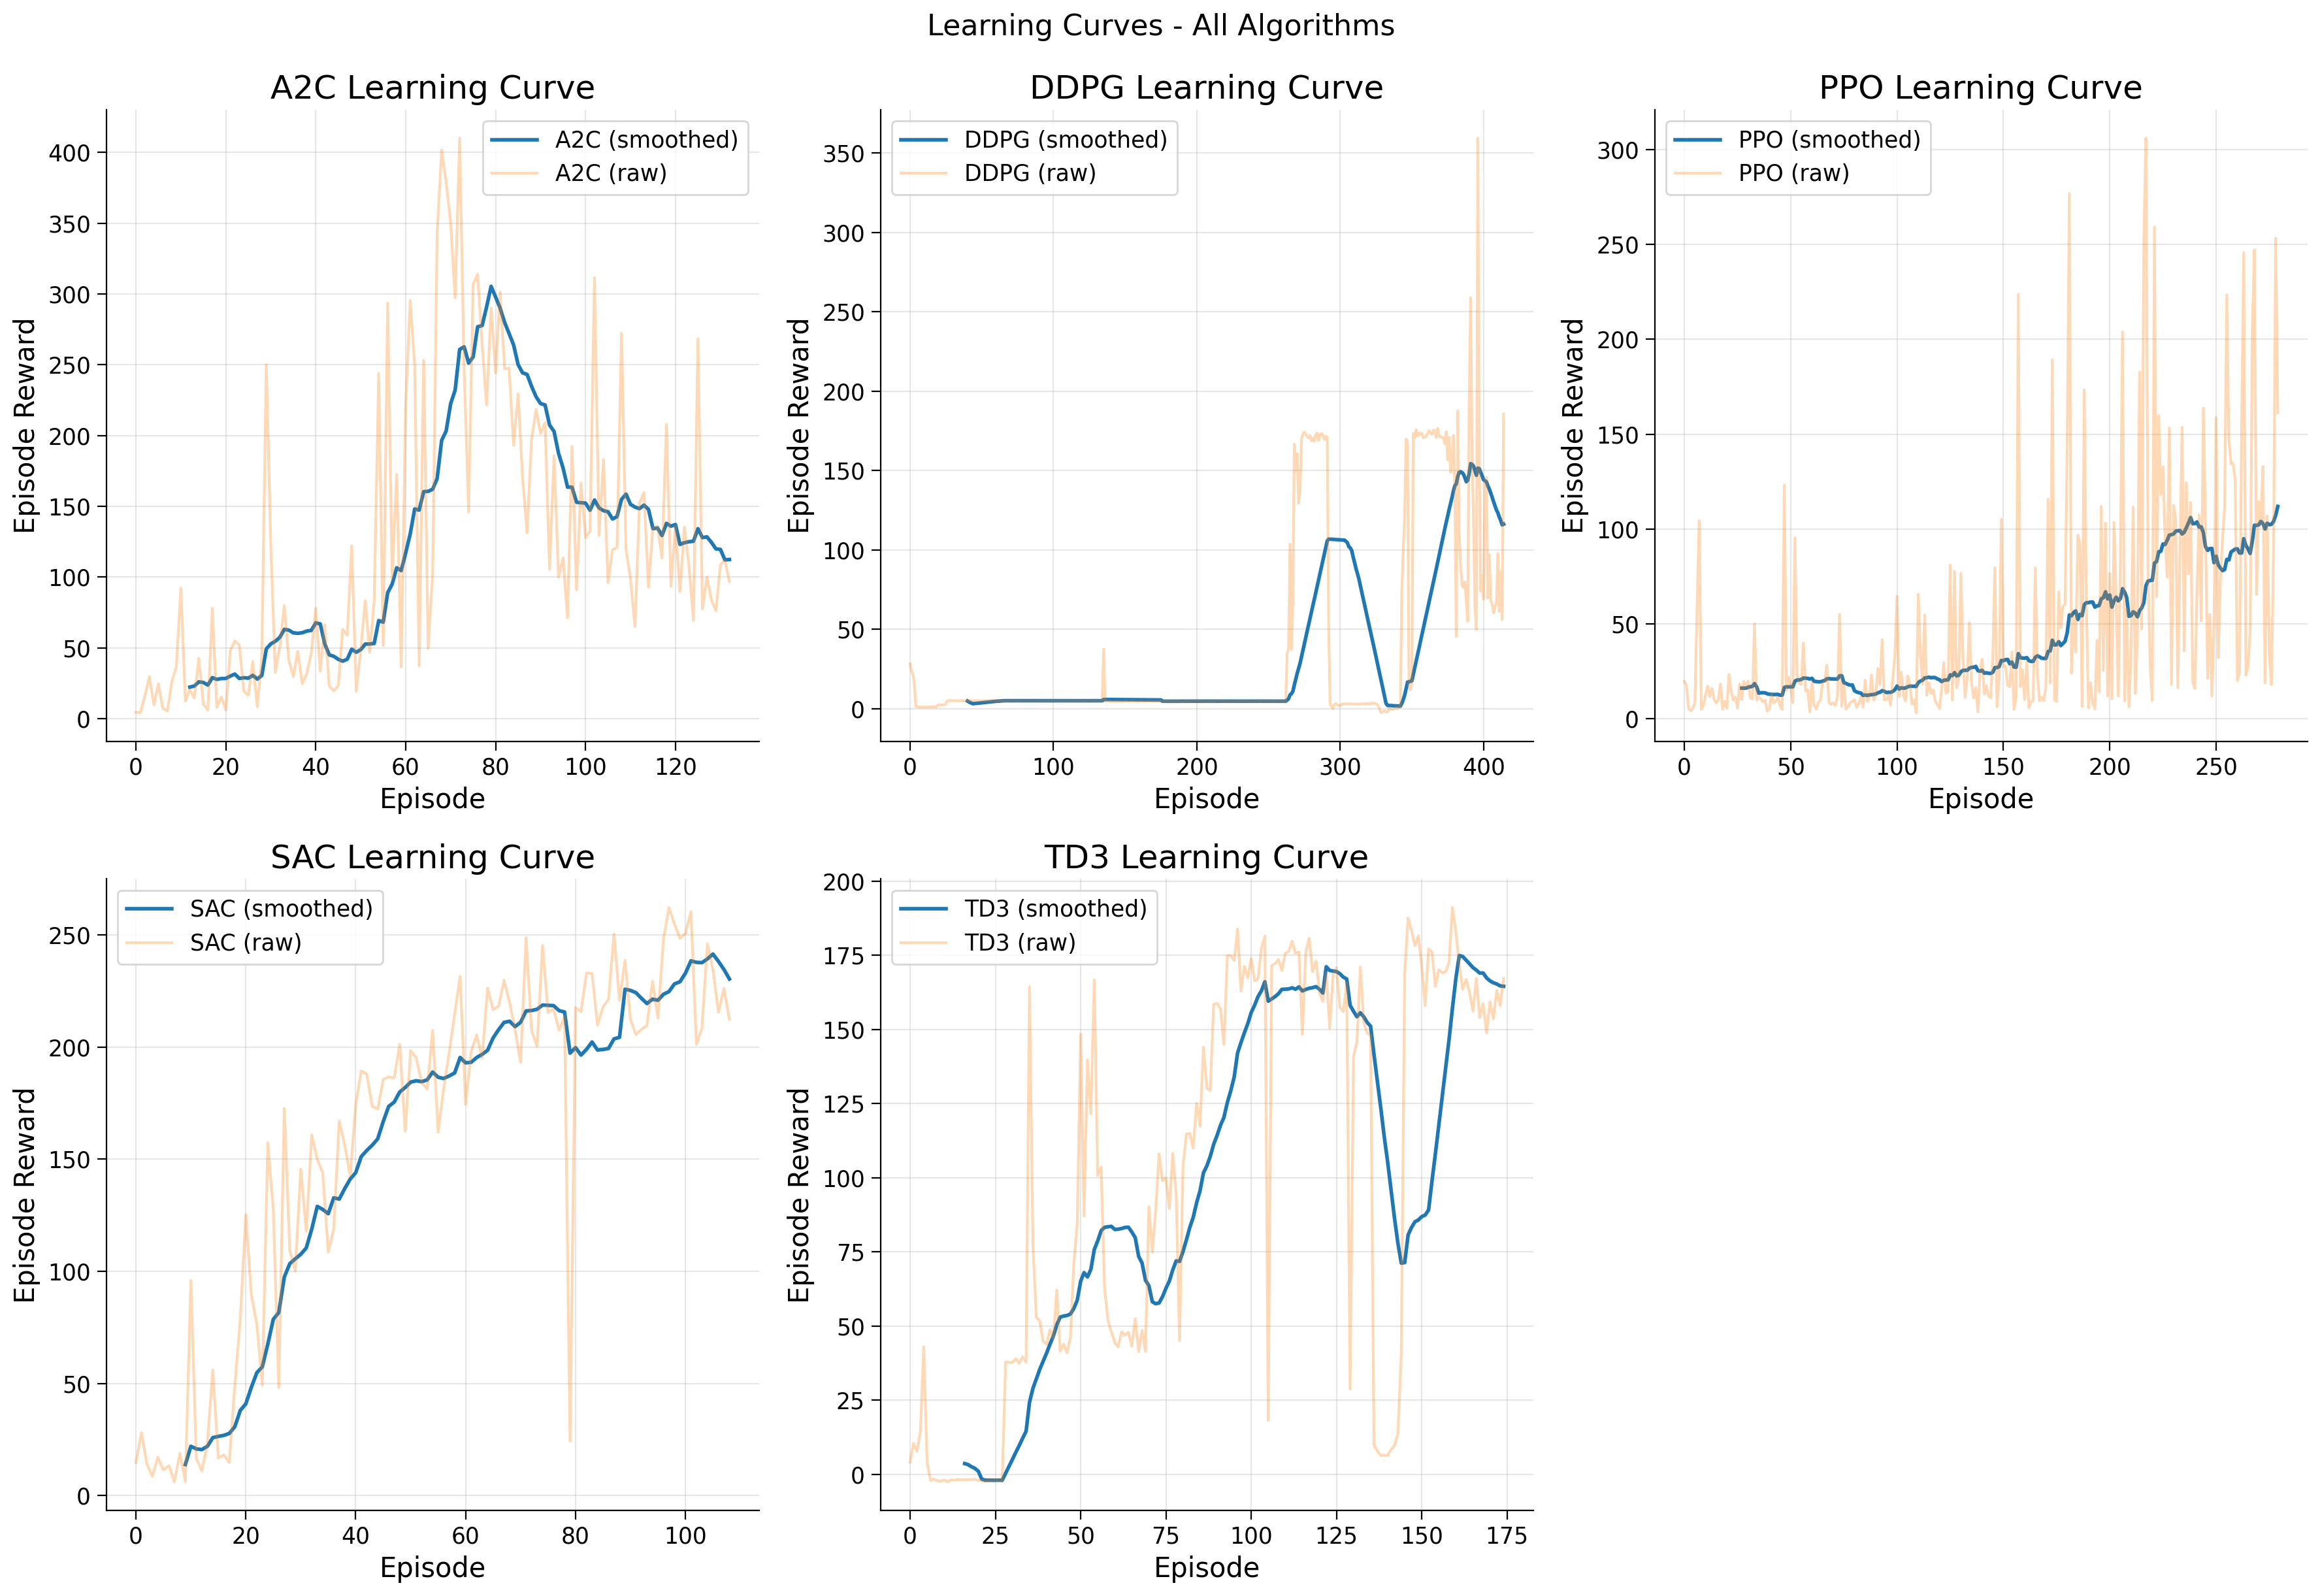

In [22]:
# @title Plot learning curves
# @markdown Plot a comparable learning curves for each algorithm
def plot_learning_curves():
    """Plot learning curves for all algorithms"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    algorithms = ['A2C', 'DDPG', 'PPO', 'SAC', 'TD3']
    callbacks = [callback_a2c, callback_ddpg, callback_ppo, callback_sac, callback_td3]

    for i, (alg, callback) in enumerate(zip(algorithms, callbacks)):
        if i < 5:  # Only plot first 5 algorithms
            ax = axes[i]

            if len(callback.rewards) > 0:
                # Calculate moving average for smoother curves
                window_size = min(50, len(callback.rewards) // 10)
                if window_size > 0:
                    rewards_smooth = np.convolve(callback.rewards,
                                               np.ones(window_size)/window_size,
                                               mode='valid')
                    episodes_smooth = np.arange(window_size-1, len(callback.rewards))

                    ax.plot(episodes_smooth, rewards_smooth, label=f'{alg} (smoothed)', linewidth=2)
                    ax.plot(callback.rewards, alpha=0.3, label=f'{alg} (raw)')
                else:
                    ax.plot(callback.rewards, label=alg)

                ax.set_title(f'{alg} Learning Curve')
                ax.set_xlabel('Episode')
                ax.set_ylabel('Episode Reward')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, f'No data for {alg}',
                       ha='center', va='center', transform=ax.transAxes)

    # Remove empty subplot
    axes[5].remove()

    plt.tight_layout()
    plt.suptitle('Learning Curves - All Algorithms', fontsize=16, y=1.02)
    plt.show()

# Plot learning curves
plot_learning_curves()

## 🎥 Performance Videos

In [23]:
print("🎥 Trained Agent Performances:")
print("=" * 50)

print("\n🎲 Random Agent (Baseline):")
display(display_video_html(video_path_random, "Random Agent Playing Hopper-v5"))
print(f"Episode reward: {reward_random:.2f}")
print("📝 Note: Random agent takes completely random actions - this shows untrained performance")

print("\n🤖 A2C Performance:")
display(display_video_html(video_path_a2c, "A2C Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_a2c:.2f}")

print("\n🤖 DDPG Performance:")
display(display_video_html(video_path_ddpg, "DDPG Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_ddpg:.2f}")

print("\n🤖 PPO Performance:")
display(display_video_html(video_path_ppo, "PPO Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_ppo:.2f}")

print("\n🤖 SAC Performance:")
display(display_video_html(video_path_sac, "SAC Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_sac:.2f}")

print("\n🤖 TD3 Performance:")
display(display_video_html(video_path_td3, "TD3 Agent Playing Hopper-v5"))
print(f"Final episode reward: {reward_td3:.2f}")

🎥 Trained Agent Performances:

🎲 Random Agent (Baseline):


Episode reward: 13.62
📝 Note: Random agent takes completely random actions - this shows untrained performance

🤖 A2C Performance:


Final episode reward: 75.55

🤖 DDPG Performance:


Final episode reward: 185.40

🤖 PPO Performance:


Final episode reward: 104.71

🤖 SAC Performance:


Final episode reward: 221.52

🤖 TD3 Performance:


Final episode reward: 163.29


## 🧮 Models Evaluation

In [ ]:
# @title Load trained models
algorithms = ['A2C', 'DDPG', 'PPO', 'SAC', 'TD3']
models = []

print("Loading trained models...")

# Load A2C model
model_a2c_loaded = A2C.load("a2c_hopper")
models.append(model_a2c_loaded)

# Load DDPG model
model_ddpg_loaded = DDPG.load("ddpg_hopper")
models.append(model_ddpg_loaded)

# Load PPO model
model_ppo_loaded = PPO.load("ppo_hopper")
models.append(model_ppo_loaded)

# Load SAC model
model_sac_loaded = SAC.load("sac_hopper")
models.append(model_sac_loaded)

# Load TD3 model
model_td3_loaded = TD3.load("td3_hopper")
models.append(model_td3_loaded)

print("\nAll videos generated successfully! ✅")

Loading trained models...

All videos generated successfully! ✅


In [ ]:
def evaluate_all_models():
    """Evaluate all trained models"""

    evaluation_env = gym.make(env_name)

    results = {}

    for alg, model in zip(algorithms, models):
        print(f"\nEvaluating {alg}...")
        mean_reward, std_reward = evaluate_policy(
            model,
            evaluation_env,
            n_eval_episodes=10,
            deterministic=True
        )
        results[alg] = {
            'mean_reward': mean_reward,
            'std_reward': std_reward
        }
        print(f"{alg}: {mean_reward:.2f} ± {std_reward:.2f}")

    evaluation_env.close()
    return results

# Evaluate all models
evaluation_results = evaluate_all_models()


Evaluating A2C...


In [ ]:
def plot_performance_comparison(results):
    """Plot performance comparison bar chart"""

    algorithms = list(results.keys())
    mean_rewards = [results[alg]['mean_reward'] for alg in algorithms]
    std_rewards = [results[alg]['std_reward'] for alg in algorithms]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(algorithms, mean_rewards, yerr=std_rewards,
                   capsize=5, color=['blue', 'red', 'green', 'orange', 'purple'])

    plt.title('Performance Comparison - All Algorithms on Hopper-v5', fontsize=14)
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Average Episode Reward', fontsize=12)
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, mean_reward in zip(bars, mean_rewards):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{mean_reward:.1f}', ha='center', va='bottom', fontsize=10)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot performance comparison
plot_performance_comparison(evaluation_results)

# 📑 Training Summary and Discussion

In [27]:
print("=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Environment: {env_name}")
print(f"Training timesteps: {TOTAL_TIMESTEPS}")
print(f"Algorithms trained: {', '.join(algorithms)}")
print("\nFinal Performance (10 episodes average):")
print("-" * 40)

for alg in algorithms:
    mean_reward = evaluation_results[alg]['mean_reward']
    std_reward = evaluation_results[alg]['std_reward']
    print(f"{alg:>8}: {mean_reward:>8.2f} ± {std_reward:>6.2f}")

print("\nAll models have been trained and evaluated successfully!")
print("Videos have been recorded and are available for viewing above.")

TRAINING SUMMARY
Environment: Hopper-v5
Training timesteps: 10000
Algorithms trained: A2C, DDPG, PPO, SAC, TD3

Final Performance (10 episodes average):
----------------------------------------
     A2C:    77.62 ±   2.98
    DDPG:   187.78 ±   5.83
     PPO:   111.50 ±   5.07
     SAC:   219.85 ±   2.28
     TD3:   164.23 ±   2.78

All models have been trained and evaluated successfully!
Videos have been recorded and are available for viewing above.


# Good Luck :)